## AutoRegression Algorithm for Anomaly Detection (AD) in Univariate Time-Series Datasets

The goal of this notebook is to provide a general implementation of the autoregression algorithm as it pertains to the problem of anomaly detection in univariate time-series datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import minmax_scale
import math

## AutoRegression for AD Implementation

The following class represents an autoregression classifier for anomaly detection on univariate time-series datasets.

#### Theoretical background and implementation steps
1. Given an ordered collection of real-valued, consecutive, and univariate time-series training data $X_1, X_2, \dots, X_n$ and a window-length hyperparameter $p$, compute an $(n - p) \times (p + 1)$ matrix, $D$, of the following form:
    $$
        D = 
        \begin{bmatrix}
            \mathbf{x_{p + 1}} \\
            \mathbf{x_{p + 2}} \\
            \vdots \\
            \mathbf{x_{n}}
        \end{bmatrix}
        =
        \begin{bmatrix}
            X_1 & X_2 & \dots & X_p & 1 \\
            X_2 & X_3 & \dots & X_{p + 1} & 1 \\
            \vdots & \vdots & \ddots & \vdots & \vdots \\
            X_{n - p} & X_{n - p + 1} & \dots & X_{n - 1} & 1
        \end{bmatrix}
    $$

    Each $p$-dimensional row vector $\mathbf{x_j}$ of the above matrix represents a window of length $p$, which will be used to predict the next value in the time-series, $X_{j}$, according to the following formula, where $a_i$ represents the ith least-squares regression coefficient, $c$ is the bias term, and $\epsilon_t$ represents the error term for the time-series point $X_t$:

    $$
        X_t = \left(\sum_{i=1}^p a_i \cdot X_{t - i}\right) + c + \epsilon_t
    $$

    Note the general form of each row vector $\mathbf{x_j}$ (this will be helpful for step 4):

    $$
        \mathbf{x_j} = 
        \begin{bmatrix}
            X_{j - p} & X_{j - p + 1} & \dots & X_{j - 1} & 1 
        \end{bmatrix}
    $$

    The absolute value of the error term, $|\epsilon_t|$, represents the anomaly score for $X_t$.

2. Compute an $(n - p)$-dimensional column vector, $\mathbf{\overline{y}}$, of the following form:

    $$
        \mathbf{\overline{y}} = 
        \begin{bmatrix}
            X_{p + 1} \\
            X_{p + 2} \\
            \vdots \\
            X_{n}
        \end{bmatrix}
    $$

3. Compute regression coefficients $a_1, a_2, \dots, a_p$ and the bias term $c$ using least squares regression in accordance with the analytical solution:

    $$
        \mathbf{a} = 
        \begin{bmatrix}
            a_{p} \\
            a_{p - 1} \\
            \vdots \\
            a_{1} \\
            c
        \end{bmatrix}
        = (D^{\mathsf{T}} D)^{-1} D^{\mathsf{T}} \mathbf{\overline{y}}
    $$

    From an implementation perspective, the `np.linalg.lstsq` function can be utilized to solve for the regression coefficients and bias term.

4. Compute each error term $\epsilon_t$ corresponding to $X_t$ according to the following formula:

    $$
        \begin{align*}
            \epsilon_t &= X_t - \left(\left(\sum_{i=1}^p a_i \cdot X_{t - i}\right) + c\right) \\
            &= X_t - 
            \begin{bmatrix}
                a_{p} \\
                a_{p - 1} \\
                \vdots \\
                a_{1} \\
                c
            \end{bmatrix}
            \cdot
            \begin{bmatrix}
                X_{t - p} \\
                X_{t - p + 1} \\
                \vdots \\
                X_{t - 1} \\
                1
            \end{bmatrix} \\
            &= X_t - \mathbf{a} \cdot \mathbf{x_t}
        \end{align*}
    $$

    Conveniently, all $\epsilon_t$ values may be computed at once using matrix multiplication, as shown below:

    $$
        \begin{align*}
            \boldsymbol{\epsilon} &=
            \begin{bmatrix}
                \epsilon_{p + 1} \\
                \epsilon_{p + 2} \\
                \vdots \\
                \epsilon_{n}
            \end{bmatrix} \\
            &= 
            \begin{bmatrix}
                X_{p + 1} - \mathbf{x_{p + 1}} \cdot \mathbf{a} \\
                X_{p + 2} - \mathbf{x_{p + 2}} \cdot \mathbf{a} \\
                \vdots \\
                X_{n} - \mathbf{x_{n}} \cdot \mathbf{a}
            \end{bmatrix} \\
            &= \mathbf{\overline{y}} - D\mathbf{a}
        \end{align*}
    $$

    Note that $\boldsymbol{\epsilon}$ is an $(n - p)$-dimensional column vector, implying that the first $p$ points are not able to be assigned anomaly scores (as they lack the previous context necessary for calculating the anomaly score).

5. Let $d$ be a hyperparameter in the range $(0, 1)$ corresponding to the percent of data points that should be considered anomalies. Define a list $\mathbf{x_d}$ which contains the $\lceil d \cdot n \rceil$ highest anomaly scores of the training data points. Define the threshold anomaly score, $|\epsilon_d|$, as the minimal anomaly score in $\mathbf{x_d}$. Using $|\epsilon_d|$, points with an anomaly score greater than or equal to $|\epsilon_d|$ will be classified as anomalous, and points with a lower anomaly score will be classified as normal.

6. Given an ordered collection of real-valued, consecutive, and univariate time-series testing data $X_1', X_2', \dots, X_m'$, where $m > p$, predict whether each testing point $X_i'$ (where $ p < i \leq m$) is anomalous or normal according to the following procedure:

    Compute an $(m - p) \times (p + 1)$ matrix, $D'$, of the following form:

    $$
        D' = 
        \begin{bmatrix}
            \mathbf{x_{p + 1}'} \\
            \mathbf{x_{p + 2}'} \\
            \vdots \\
            \mathbf{x_{n}'}
        \end{bmatrix}
        =
        \begin{bmatrix}
            X_1' & X_2' & \dots & X_p' & 1 \\
            X_2' & X_3' & \dots & X_{p + 1}' & 1 \\
            \vdots & \vdots & \ddots & \vdots & \vdots \\
            X_{m - p}' & X_{m - p + 1}' & \dots & X_{m - 1}' & 1
        \end{bmatrix}
    $$

    Compute an $(m - p)$-dimensional column vector, $\mathbf{\overline{y}'}$, of the following form:

    $$
        \mathbf{\overline{y}'} = 
        \begin{bmatrix}
            X_{p + 1}' \\
            X_{p + 2}' \\
            \vdots \\
            X_{m}'
        \end{bmatrix}
    $$

    Compute an $(m - p)$-dimensional column vector of error terms, $\boldsymbol{\epsilon'}$, using matrix multiplication of $D'$ with the regression coefficients:

    $$
        \boldsymbol{\epsilon'} = 
        \begin{bmatrix}
                \epsilon_{p + 1}' \\
                \epsilon_{p + 2}' \\
                \vdots \\
                \epsilon_{m}'
            \end{bmatrix}
        = \mathbf{\overline{y}'} - D'\mathbf{a}
    $$

    For each testing point $X_i'$ (where $ p < i \leq m$), compare the corresponding anomaly score $|\epsilon_i'|$ with $|\epsilon_d|$. If $|\epsilon_i'|$ is greater than or equal to $|\epsilon_d|$, classify $X_i'$ as anomalous. Otherwise, classify $X_i'$ as normal.

In [2]:
class AR:
    """ Represents an AutoRegression (AR) classifier for anomaly detection on
        univariate time-series datasets.

        Fields: 
            self.X (ndarray of shape (n_samples,)):
                The univariate training data, or training points. Assumes that
                all points in self.X are real-valued, consecutive, and
                univariate time-series points.
            self.y (ndarray of shape (n_samples,)):
                The anomaly labels corresponding to the training points in X. A
                label of 0 corresponds with normal points, while a label of 1
                corresponds with anomalous points.
            self.window_size (int):
                The number of data points to use per window when performing the
                autoregression. Must be strictly greater than 0 and strictly
                less than n_samples.
            self.a (ndarray of shape (self.window_size + 1,)):
                The regression coefficients and bias term based on the training
                data (self.X).
            self.anomaly_scores (ndarray of shape
                                 (n_samples - self.window_size,)):
                The anomaly scores for each of the training points in self.X
                (excluding the first self.window_size points).
            self.anomaly_score_threshold (float):
                The anomaly score which determines the cutoff point for
                classifying points as normal or anomalous. Points with an
                anomaly score greater than or equal to
                self.anomaly_score_threshold are considered anomalous, and
                points with a lower anomaly score are considered normal. This
                value is dependedent on the anomaly_rate parameter in the
                constructor.
    """
    
    def __init__(self, X, y, window_size=5, anomaly_rate=0.1):
        """ Initializes an AR classifier object. This is an expensive function,
        as the model is fit (i.e., linear regression is performed) as a result
        of instantiating an AR object.

        Args:
            X (ndarray of shape (n_samples,)):
                The univariate training data, or training points. Assumes that
                all points in self.X are real-valued, consecutive, and
                univariate time-series points.
            y (ndarray of shape (n_samples,)):
                The anomaly labels corresponding to the training points in X. A
                label of 0 corresponds with normal points, while a label of 1
                corresponds with anomalous points.
            window_size (int, optional):
                The number of data points to use per window when performing the
                autoregression. Must be strictly greater than 0 and strictly
                less than n_samples.
            anomaly_rate (float):
                Corresponds with the percentage of training points that should
                be considered anomalous; that is, (anomaly_rate * 100)% of
                training points will be classified as anomalies. Must be in the
                range (0, 1]. Directly influences the anomaly score threshold
                used when predicting anomaly labels of novel points.

        Raises:
            TypeError:
                If X or y are not ndarrays, if window_size is not an integer, or
                if anomaly_rate is not a float.
            ValueError:
                If X is an ndarray with more than one dimension, if X and y have
                different shapes, if y contains elements not in the set {0, 1},
                if window_size is not in the range (0, n_samples), or if
                anomaly_rate is not in the range (0, 1].
        """
        if not isinstance(X, np.ndarray):
            raise TypeError("X must be an ndarray.")
        if X.ndim != 1:
            raise ValueError("X must be an ndarray of shape (n_samples,).")
        if not isinstance(y, np.ndarray):
            raise TypeError("y must be an ndarray.")
        if X.shape != y.shape:
            raise ValueError("X and y must have the same shape.")
        if not np.array_equal(np.unique(y).astype(np.int64),
                              np.array([0, 1], dtype=np.int64)):
            raise ValueError("y must only contain elements in the set {0, 1}.")
        if not isinstance(window_size, int):
            raise TypeError("window_size must be an integer.")
        if window_size <= 0 and window_size >= X.shape[0]:
            raise ValueError("window_size must be in the range (0, n_samples), "
                             + "where n_samples is the size of the training "
                             + "dataset (X.shape[0])")
        if not isinstance(anomaly_rate, float):
            raise TypeError("anomaly_rate must be a float.")
        if anomaly_rate <= 0.0 or anomaly_rate > 1.0:
            raise ValueError("anomaly_rate must be in the range (0, 1].")
        
        self.X = X
        self.y = y
        self.window_size = window_size
        self.a = None
        self.anomaly_scores = None
        self.anomaly_score_threshold = None
        self._fit(anomaly_rate)

    def _fit(self, anomaly_rate):
        """ Private helper function that fits the AutoRegression classifier by 
            constructing the appropriate matrices and performing linear
            regression. Also sets the proper anomaly score threshold after
            regression has been performed. Assumes that self.X and
            self.window_size have been properly instantiated.

        Args:
            anomaly_rate (float):
                Corresponds with the percentage of training points that should
                be considered anomalous; that is, (anomaly_rate * 100)% of
                training points will be classified as anomalies. Must be in the
                range (0, 1]. Directly influences the anomaly score threshold
                used when predicting anomaly labels of novel points.
        """
        n_samples = self.X.shape[0]

        # Construct D
        D = np.empty((n_samples - self.window_size, self.window_size + 1))
        for i in range(D.shape[0]):
            for j in range(D.shape[1] - 1):
                D[i, j] = self.X[j + i]
            D[i, self.window_size] = 1.0
        
        # Construct y (autoregression labels, different from self.y)
        y_bar = np.empty(n_samples - self.window_size)
        for i in range(y_bar.shape[0]):
            y_bar[i] = self.X[i + self.window_size]

        # Compute regression coefficients (a) and residuals
        a, _, _, _ = np.linalg.lstsq(D, y_bar, rcond=None)
        self.a = a

        residuals = y_bar - D @ a
        self._compute_anomaly_score_threshold(anomaly_rate, residuals)


    def _compute_anomaly_score_threshold(self, anomaly_rate, residuals):
        """ Computes the anomaly score threshold value, given an anomaly rate.
            Formally, this is defined as the minimal anomaly score of the top
            (anomaly_rate * 100)% of training points with anomaly scores.

        Args:
            anomaly_rate (float):
                Corresponds with the percentage of training points with anomaly
                scores that should be considered anomalous; that is,
                (anomaly_rate * 100)% of training points with anomaly scores
                will be classified as anomalies. Must be in the range (0, 1].
                Directly influences the anomaly score threshold used when
                predicting anomaly labels of novel points.
            residuals (ndarray of shape (n_samples - self.window_size)):
                The error terms for each of the points in self.X (excluding the
                first self.window_size points).
        """
        num_anomaly_scores = math.ceil(anomaly_rate * residuals.shape[0])
        anomaly_scores = np.abs(residuals)
        self.anomaly_scores = anomaly_scores
        sorted_anom_scores = np.sort(anomaly_scores)
        self.anomaly_score_threshold = sorted_anom_scores[-num_anomaly_scores]

    def predict(self, X=None):
        """ Classifies the points in X (except for the first self.window_size
        points) as normal (0) or anomalous (1) using
        self.anomaly_score_threshold, which was computed when the object was
        instantiated. If X is None, predictions are made for all training
        examples in self.X, except for the first self.window_size points.

        Args:
            X (ndarray of shape (n_queries,), optional):
                The points to classify as normal or anomalous. Assumes that all
                points in X are real-valued, consecutive, and univariate
                time-series points drawn from the same dataset as the training
                points (self.X). If X is None, predictions are made for all
                training examples in self.X, except for the first
                self.window_size points. Defaults to None.

        Returns:
            y (ndarray of shape (n_queries - self.window_size,)):
                The predicted labels for each point in X, except for the first
                self.window_size points. 1 corresponds to anomalous points, and
                0 corresponds to normal points.
        """
        anomaly_scores = self.predict_anomaly_scores(X=X)
        y = np.empty(anomaly_scores.shape[0])
        for i, anomaly_score in enumerate(anomaly_scores):
            y[i] = 1 if anomaly_score >= self.anomaly_score_threshold else 0
        return y

    def predict_anomaly_scores(self, X=None):
        """ Calculates the anomaly scores of each point in X, excluding the
            first self.window_size points. If X is None, anomaly scores are
            obtained for all training examples (self.X), except for the first
            self.window_size points.

        Args:
            X (ndarray of shape (n_queries,), optional):
                The points for which anomaly scores will be calculated. Assumes
                that all points in X are real-valued, consecutive, and
                univariate time-series points drawn from the same dataset as
                the training points (self.X). If X is None, anomaly scores are
                calculated for all training examples (self.X), except for the
                first self.window_size points. Defaults to None.

        Raises:
            TypeError:
                If X is not an ndarray.
            ValueError:
                If X has more than one dimension, or if n_queries is less than
                or equal to self.window_size.

        Returns:
            anomaly_scores (ndarray of shape (n_queries - self.window_size,)):
                The anomaly scores corresponding to each point in X, except for
                the first self.window_size points.
        """
        # The anomaly scores for the training data have already been computed
        if X is None:
            return self.anomaly_scores

        # Ensure valid type/value of X (if it is not None)
        if not isinstance(X, np.ndarray):
            raise TypeError("X must be an ndarray.")
        if X.ndim != 1:
            raise ValueError("X must be an ndarray of shape (n_queries,).")
        n_queries = X.shape[0]
        if n_queries <= self.window_size:
            raise ValueError("The number of points in X must be greater than " +
                             "self.window_size.")

        # Construct D_prime
        D_prime = np.empty((n_queries - self.window_size, self.window_size + 1))
        for i in range(D_prime.shape[0]):
            for j in range(D_prime.shape[1] - 1):
                D_prime[i, j] = self.X[j + i]
            D_prime[i, self.window_size] = 1.0
        
        # Construct y_bar_prime (autoregression labels, different from self.y)
        y_bar_prime = np.empty(n_queries - self.window_size)
        for i in range(y_bar_prime.shape[0]):
            y_bar_prime[i] = self.X[i + self.window_size]
        
        anomaly_scores = np.abs(y_bar_prime - D_prime @ self.a)
        return anomaly_scores

    def predict_proba(self, X=None):
        """ Calculates the "probability" of each point in X being an anomaly,
            except for the first self.window_size points. The "probability" is
            simply defined as the normalized version of the anomaly score array.

        Args:
            X (ndarray of shape (n_queries,), optional):
                The points for which "probabilities" will be calculated (except
                for the first self.window_size points). If X is None,
                predictions are made for all training examples in self.X, except
                for the first self.window_size points. Defaults to None.

        Returns:
            probs (ndarray of shape (n_queries - self.window_size,)):
                The "probabilities" corresponding to each point in X.
        """
        return minmax_scale(self.predict_anomaly_scores(X=X))

    def c_matrix(self, X=None, y=None):
        """ Computes a confusion matrix based on X and y.

        Args:
            X (ndarray of shape (n_queries,), optional):
                The points for which classifier performance will be evaluated on
                (except for the first self.window_size points). If X is None,
                predictions are made for all training examples in self.X, except
                for the first self.window_size points. If y is None, X must also
                be None. Defaults to None.
            y (ndarray of shape (n_queries,), optional):
                The labels for each point in X. 1 corresponds to anomalous
                points, and 0 corresponds to normal points. If y is None, the
                provided scoring metric is calculated for predictions made for
                the training set. If X is None, y must also be None. Defaults to
                None.

        Raises:
            TypeError:
                If one of X or y is None, but the other is not None, a TypeError
                is raised.

        Returns:
            c_matrix (ndarray of shape (2, 2)):
                The confusion matrix. Position (0, 0) corresponds with correctly
                identified normal points (true negatives), position (0, 1)
                corresponds with incorrectly identified normal points (false
                positives), position (1, 0) corresponds with incorrectly
                identified anomalies (false negatives), and position (1, 1)
                corresponds with correctly identified anomalies (true
                positives).
        """
        if y is not None and X is None or y is None and X is not None:
            raise TypeError('If one of X or y is None, the other must also ' +
                            'be None.')                  

        # If y is None, self.y will be used instead (since X must also be None)
        y_queries = self.y if y is None else y
        y_pred = self.predict(X=X)
        
        # Compute confusion matrix to obtain relevant counts
        c_matrix = metrics.confusion_matrix(y_queries[self.window_size:],
                                            y_pred)
        return c_matrix

    def score(self, X=None, y=None, metric='accuracy'):
        """ Computes various metrics (accuracy, precision, or recall) of the
            AutoRegression classifier on a given set of points (X) with
            corresponding labels (y). If X and y are both None, the performance
            of the classifier on the training data will be computed.

        Args:
            X (ndarray of shape (n_queries,), optional):
                The points for which classifier performance will be evaluated on
                (except for the first self.window_size points). If X is None,
                predictions are made for all training examples in self.X, except
                for the first self.window_size points. If y is None, X must also
                be None. Defaults to None.
            y (ndarray of shape (n_queries,), optional):
                The labels for each point in X. 1 corresponds to anomalous
                points, and 0 corresponds to normal points. If y is None, the
                provided scoring metric is calculated for predictions made for
                the training set. If X is None, y must also be None. Defaults to
                None.
            metric (string, optional): 
                Corresponds to the desired statistical metric to evaluate the
                performance of the classifier. Must be one of 'accuracy',
                'precision', or 'recall'. Defaults to 'accuracy'.

        Raises:
            TypeError:
                If one of X or y is None, but the other is not None, a TypeError
                is raised.
            ValueError:
                If metric is not one of 'accuracy', 'precision', or 'recall', a
                ValueError is raised.

        Returns:
            score (float):
                A numerical value corresponding to the performance of the
                classifier, where the performance is measured by the specified
                metric. 
        """
        c_matrix = self.c_matrix(X=X, y=y)
        true_neg  = c_matrix[0][0] # Correctly identified normal points
        false_pos = c_matrix[0][1] # Incorrectly identified normal points
        false_neg = c_matrix[1][0] # Incorrectly identified anomalies
        true_pos  = c_matrix[1][1] # Correctly identified anomalies

        def calc_precision():
            num_selected = true_pos + false_pos
            return true_pos / num_selected if num_selected != 0 else 1.0

        def calc_recall():
            num_relevant = true_pos + false_neg
            return true_pos / num_relevant if num_relevant != 0 else 1.0

        # Evaluate score based on the desired metric
        if metric == 'accuracy':
            return (true_pos + true_neg) / (true_pos + true_neg + false_pos + \
                                            false_neg)
        elif metric == 'precision':
            return calc_precision()
        elif metric == 'recall':
            return calc_recall()
        elif metric == 'f1':
            precision = calc_precision()
            recall = calc_recall()
            return (2 * precision * recall) / (1.0 if precision + recall == 0
                                                   else precision + recall)
        elif metric == 'tpr':
            num_pos = true_pos + false_neg
            return true_pos / num_pos if num_pos != 0 else 0.0
        elif metric == 'fpr':
            num_neg = false_pos + true_neg
            return false_pos / num_neg if num_neg != 0 else 0.0
        raise ValueError("Invalid metric specified.")

## Application of AutoRegression to a Labelled Anomaly Dataset

The dataset of choice for applying this AutoRegression implementation for time-series anomaly detection is the KPI dataset, which can be found [here](https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/TRAIN/dataset_TRAIN/tables/learningData.csv). Testing data for the same dataset can be found [here](https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/TEST/dataset_TEST/tables/learningData.csv).

In [3]:
# Obtain training dataset
kpi_path = 'https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/'
train_data = pd.read_csv(kpi_path + 'TRAIN/dataset_TRAIN/tables/learningData.csv')
train_data

,d3mIndex,timestamp,value,ground_truth
0,0,1472918400,0.234191,0
1,1,1472918700,0.236657,0
2,2,1472919000,0.230887,0
3,3,1472919300,0.217486,0
4,4,1472919600,0.223722,0
...,...,...,...,...
7022,7022,1475025000,0.283260,0
7023,7023,1475025300,0.291378,0
7024,7024,1475025600,0.308455,0
7025,7025,1475025900,0.309410,0


In [4]:
# Obtain testing dataset
test_data = pd.read_csv(kpi_path + 'TEST/dataset_TEST/tables/learningData.csv')
test_data

,d3mIndex,timestamp,value,ground_truth
0,7027,1475026500,0.322647,0
1,7028,1475026800,0.321834,0
2,7029,1475027100,0.317879,0
3,7030,1475027400,0.329673,0
4,7031,1475027700,0.330722,0
...,...,...,...,...
1752,8779,1475552100,0.305849,0
1753,8780,1475552400,0.308899,0
1754,8781,1475552700,0.307782,0
1755,8782,1475553000,0.309060,0


In [5]:
# There are 10 data points labelled as anomalies in the training dataset
train_data['ground_truth'].value_counts()

0    7017
1      10
Name: ground_truth, dtype: int64

In [6]:
# There are 3 data points labelled as anomalies in the training dataset
test_data['ground_truth'].value_counts()

0    1754
1       3
Name: ground_truth, dtype: int64

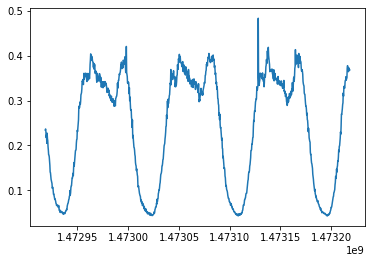

In [7]:
plt.plot(train_data['timestamp'][:1000], train_data['value'][:1000])
plt.show()

In [8]:
# Segment training and testing data appropriately
X_train = train_data['value'].to_numpy()
print(X_train.shape)
y_train = train_data['ground_truth'].to_numpy()
print(y_train.shape)
X_test = test_data['value'].to_numpy()
print(X_test.shape)
y_test = test_data['ground_truth'].to_numpy()
print(y_test.shape)

(7027,)
(7027,)
(1757,)
(1757,)


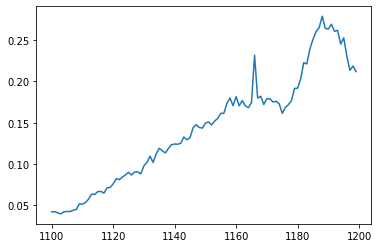

In [9]:
plt.plot(range(1100, 1200), X_test[1100:1200])
plt.show()

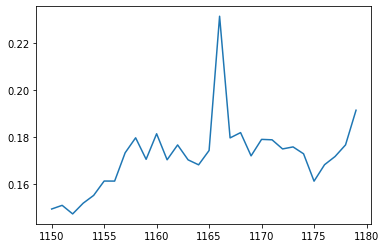

In [10]:
plt.plot(range(1150, 1180), X_test[1150:1180])
plt.show()

Training F1: 0.02244039270687237
Testing F1: 0.0


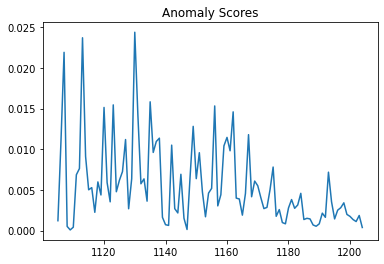

Anomalous point: 0.1743518278146261 (1165), Anomaly Score: 0.0018999478245445012
Anomalous point: 0.2315387842193244 (1166), Anomaly Score: 0.0045724861836295705
Anomalous point: 0.1797029262577859 (1167), Anomaly Score: 0.011799995393845603


In [11]:
# Fit the model and evaluate its performance on testing data
ar = AR(X_train, y_train)
print('Training F1:', ar.score(metric='f1'))
print('Testing F1:', ar.score(X=X_test, y=y_test, metric='f1'))
anomaly_scores_test = ar.predict_anomaly_scores(X=X_test)
plt.title("Anomaly Scores")
plt.plot(range(1100 + ar.window_size, 1200 + ar.window_size),
         anomaly_scores_test[1100:1200])
plt.show()

for i, label in enumerate(y_test[ar.window_size:]):
    if label == 1:
        print(f'Anomalous point: {X_test[i + ar.window_size]}',
              f'({i + ar.window_size}),',
              f'Anomaly Score: {anomaly_scores_test[i]}')

## AutoRegression Evaluation

To evaluate the performance of the AutoRegression classifier on the KPI dataset, both an ROC curve and a PR curve were plotted. The AUC metric for each curve is also shown (for the PR curves, the nearly-equivalent metric of average precision, or AP, is calculated instead). Different plots correspond to AutoRegression models with different `window_size` values.

In [12]:
# Initialize AR classifiers for hyperparameter tuning
window_sizes = [10, 15, 20, 50, 100, 500]
anomaly_rates = [0.00001, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
ars = {}
for window_size in window_sizes:
    for anomaly_rate in anomaly_rates:
        ars[(window_size, anomaly_rate)] = AR(X=X_train, y=y_train,
                                              window_size=window_size,
                                              anomaly_rate=anomaly_rate)

In [13]:
# Find AR with optimal F1 score (on testing data)
max_pair = None
max_f1 = None
for pair, ar in ars.items():
    f1 = ar.score(X=X_test, y=y_test, metric='f1')
    if max_f1 is None or f1 > max_f1:
        max_f1 = f1
        max_pair = pair

print(f'Window size: {max_pair[0]}, anomaly rate: {max_pair[1]}: F1={max_f1}')

Window size: 500, anomaly rate: 0.5: F1=0.005830903790087464


In [14]:
# Function for printing detailed metrics for the AR with optimal F1 score
def summarize_results(pair):
      print(f'Results for testing data (window_size={pair[0]},',
            f'anomaly_rate={pair[1]}):')
      print('Confusion matrix:')
      print(ars[pair].c_matrix(X=X_test, y=y_test))
      print('False positive rate (FPR):',
            ars[pair].score(X=X_test, y=y_test, metric='fpr'))
      print('True positive rate (TPR):',
            ars[pair].score(X=X_test, y=y_test, metric='tpr'))
      print('Precision:',
            ars[pair].score(X=X_test, y=y_test, metric='precision'))
      print('Recall:',
            ars[pair].score(X=X_test, y=y_test, metric='recall'))
      print('F1 score:',
            ars[pair].score(X=X_test, y=y_test, metric='f1'))
      print('Accuracy:',
            ars[pair].score(X=X_test, y=y_test, metric='accuracy'))

      print(f'\nResults for training data (window_size={pair[0]},',
            f'anomaly_rate={pair[1]}):')
      print('Confusion matrix:')
      print(ars[pair].c_matrix())
      print('False positive rate (FPR):',
            ars[pair].score(metric='fpr'))
      print('True positive rate (TPR):',
            ars[pair].score(metric='tpr'))
      print('Precision:',
            ars[pair].score(metric='precision'))
      print('Recall:',
            ars[pair].score(metric='recall'))
      print('F1 score:',
            ars[pair].score(metric='f1'))
      print('Accuracy:',
            ars[pair].score(metric='accuracy'))

In [15]:
summarize_results(max_pair)

Results for testing data (window_size=500, anomaly_rate=0.5):
Confusion matrix:
[[573 681]
 [  1   2]]
False positive rate (FPR): 0.5430622009569378
True positive rate (TPR): 0.6666666666666666
Precision: 0.0029282576866764276
Recall: 0.6666666666666666
F1 score: 0.005830903790087464
Accuracy: 0.45743834526650756

Results for training data (window_size=500, anomaly_rate=0.5):
Confusion matrix:
[[3263 3258]
 [   0    6]]
False positive rate (FPR): 0.49961662321729794
True positive rate (TPR): 1.0
Precision: 0.001838235294117647
Recall: 1.0
F1 score: 0.0036697247706422016
Accuracy: 0.5008426535927685


In [16]:
# Find AR with optimal F1 score (on training data)
max_pair_train = None
max_f1_train = None
for pair, ar in ars.items():
    f1 = ar.score(metric='f1')
    if max_f1_train is None or f1 > max_f1_train:
        max_f1_train = f1
        max_pair_train = pair

print(f'Window size: {max_pair_train[0]}, anomaly rate: {max_pair_train[1]}:',
      f'F1={max_f1_train}')

Window size: 500, anomaly rate: 0.001: F1=0.6153846153846153


In [17]:
summarize_results(max_pair_train)

Results for testing data (window_size=500, anomaly_rate=0.001):
Confusion matrix:
[[1249    5]
 [   3    0]]
False positive rate (FPR): 0.003987240829346092
True positive rate (TPR): 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9936356404136834

Results for training data (window_size=500, anomaly_rate=0.001):
Confusion matrix:
[[6518    3]
 [   2    4]]
False positive rate (FPR): 0.00046005213924244745
True positive rate (TPR): 0.6666666666666666
Precision: 0.5714285714285714
Recall: 0.6666666666666666
F1 score: 0.6153846153846153
Accuracy: 0.9992339512793014


In [18]:
ar10 = AR(X=X_train, y=y_train, window_size=10, anomaly_rate=0.1)
print(ar10.score(X=X_test, y=y_test, metric='f1'))
print(ar10.score(X=X_test, y=y_test, metric='precision'))
print(ar10.score(X=X_test, y=y_test, metric='recall'))
print(ar10.score(X=X_test, y=y_test, metric='accuracy'))
print(ar10.c_matrix(X=X_test, y=y_test))

0.0
0.0
0.0
0.8637664567830566
[[1509  235]
 [   3    0]]
